# Assemble data needed for KOIs

In [2]:
%matplotlib inline

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from astropy.table import Table

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load the data files.

In [128]:
# CKS catalogue:
cks = pd.read_csv("../data/cks_physical_merged.csv")

# McQuillan catalogue:
mc = pd.read_csv("../data/Table_1_Periodic.txt")

# Tim and my catalogue:
tdmra = pd.read_csv("../data/koi_periods_0712.csv")

# Mazeh catalog
ma = pd.read_csv("../data/mazeh.csv", skiprows=73, delimiter=";")

# Gaia DR2
dat = Table.read("../data/kepler_dr2_1arcsec.fits", format='fits')
dr2 = dat.to_pandas()

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: TableReplaceWarning: converted column 'r_result_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: TableReplaceWarning: converted column 'r_modality_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: TableReplaceWarning: converted column 'teff_err1' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: TableReplaceWarning: converted column 'teff_err2' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


In [161]:
for k in cks.keys():
    print(k)

id_starname
id_kic
id_koicand
id_kepler_name
koi_disposition
koi_period
koi_period_err1
koi_period_err2
koi_time0
koi_time0_err1
koi_time0_err2
koi_impact
koi_impact_err1
koi_impact_err2
koi_duration
koi_duration_err1
koi_duration_err2
koi_ingress
koi_ingress_err1
koi_ingress_err2
koi_depth
koi_depth_err1
koi_depth_err2
koi_ror
koi_ror_err1
koi_ror_err2
koi_srho
koi_srho_err1
koi_srho_err2
koi_prad
koi_prad_err1
koi_prad_err2
koi_sma
koi_sma_err1
koi_sma_err2
koi_teq
koi_teq_err1
koi_teq_err2
koi_insol
koi_insol_err1
koi_insol_err2
koi_dor
koi_dor_err1
koi_dor_err2
koi_max_mult_ev
koi_model_snr
koi_count
koi_num_transits
koi_steff
koi_steff_err1
koi_steff_err2
koi_slogg
koi_slogg_err1
koi_slogg_err2
koi_smet
koi_smet_err1
koi_smet_err2
koi_srad
koi_srad_err1
koi_srad_err2
koi_smass
koi_smass_err1
koi_smass_err2
koi_sage
koi_sage_err1
koi_sage_err2
koi_sparprov
kic_kepmag
kic_jmag
kic_hmag
kic_kmag
cks_fp
cks_steff
cks_steff_err1
cks_steff_err2
cks_slogg
cks_slogg_err1
cks_slogg_err2
ck

Merge McQuillan and Gaia (for plotting CMD).

In [129]:
mc = pd.merge(mc, dr2, left_on="kepid", right_on="kepid", how="inner")

Merge CKS and Gaia/Kepler catalogs.

In [130]:
cks["kepid"] = cks.id_kic
cks_gaia = pd.merge(cks, dr2, on="kepid", how="left", suffixes=["_cks", "_gaia"])
print(np.shape(cks), np.shape(dr2), np.shape(cks_gaia))
cks_gaia = cks_gaia.drop_duplicates(subset="kepid")
print(np.shape(cks_gaia))

(2025, 121) (201312, 134) (2041, 254)
(1279, 254)


Merge with the Mazeh stellar rotation catalog.

In [131]:
cks_gaia_prot = pd.merge(cks_gaia, ma, left_on="kepid", right_on="KIC", how="inner")
print(np.shape(cks_gaia), np.shape(ma), np.shape(cks_gaia_prot))

df = cks_gaia_prot

(1279, 254) (3355, 21) (1129, 275)


Merge with Tim and my rotation catalog.

In [132]:
tdmra.keys()

Index(['Unnamed: 0', 'KOI', 'feh', 'feh_errm', 'feh_errp', 'logg', 'logg_errm',
       'logg_errp', 'period', 'period_errm', 'period_errp', 'teff',
       'teff_errm', 'teff_errp'],
      dtype='object')

In [133]:
ro1 = pd.merge(tdmra, cks_gaia_prot, on="KOI", how="inner")
print(np.shape(tdmra), np.shape(ma), np.shape(ro1))

(1102, 14) (3355, 21) (973, 288)


Compare rotation period measurements.

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


<ErrorbarContainer object of 3 artists>

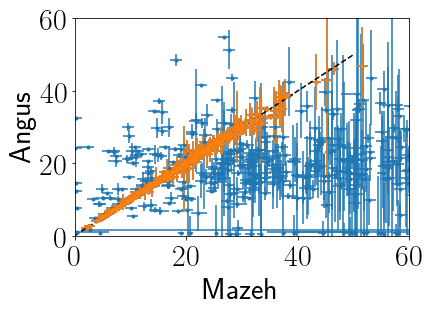

In [134]:
plt.errorbar(ro1.Prot, ro1.period, yerr=ro1.e_Prot, xerr=[ro1.period_errm, ro1.period_errp], fmt=".")
xs = np.linspace(0, 50, 100)
plt.plot(xs, xs, "k", ls="--")
plt.xlabel("Mazeh")
plt.ylabel("Angus")
plt.xlim(0, 60)
plt.ylim(0, 60)

# Select stars that agree within 10%.
m = (ro1.Prot.values*0.9 < ro1.period.values) * (ro1.period.values < ro1.Prot.values*1.1)
plt.errorbar(ro1.Prot.values[m], ro1.period.values[m], 
             yerr=ro1.e_Prot.values[m], xerr=[ro1.period_errm.values[m], ro1.period_errp.values[m]],
             fmt=".")

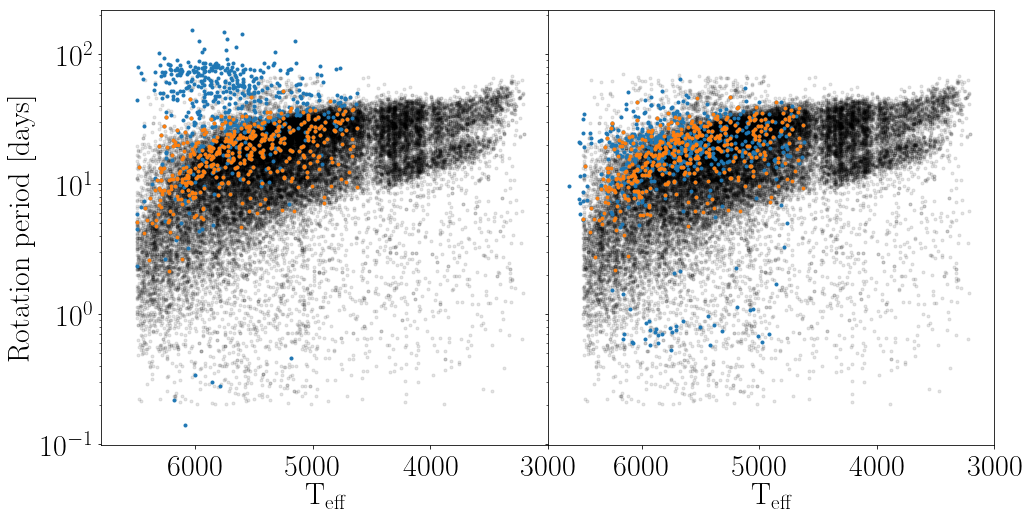

In [135]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
ax1.plot(mc.Teff, mc.Prot, "k.", alpha=.1)
ax1.plot(ro1.Teff, ro1.Prot, ".")
ax1.plot(ro1.Teff.values[m], ro1.Prot.values[m], "C1.")
ax1.set_xlim(6800, 3000)
ax1.set_yscale("log")
ax1.set_ylabel("$\mathrm{Rotation~period~[days]}$")
ax1.set_xlabel("$\mathrm{T_{eff}}$")

ax2 = fig.add_subplot(122, sharey=ax1)
ax2.plot(mc.Teff, mc.Prot, "k.", alpha=.1)
ax2.plot(ro1.Teff, ro1.period, ".")
ax2.plot(ro1.Teff.values[m], ro1.period.values[m], "C1.")
ax2.set_xlim(6800, 3000)
ax2.set_yscale("log")
ax2.set_xlabel("$\mathrm{T_{eff}}$")

plt.setp(ax2.get_yticklabels(), visible=False)
plt.subplots_adjust(wspace=0)

Plot stars on the CMD.

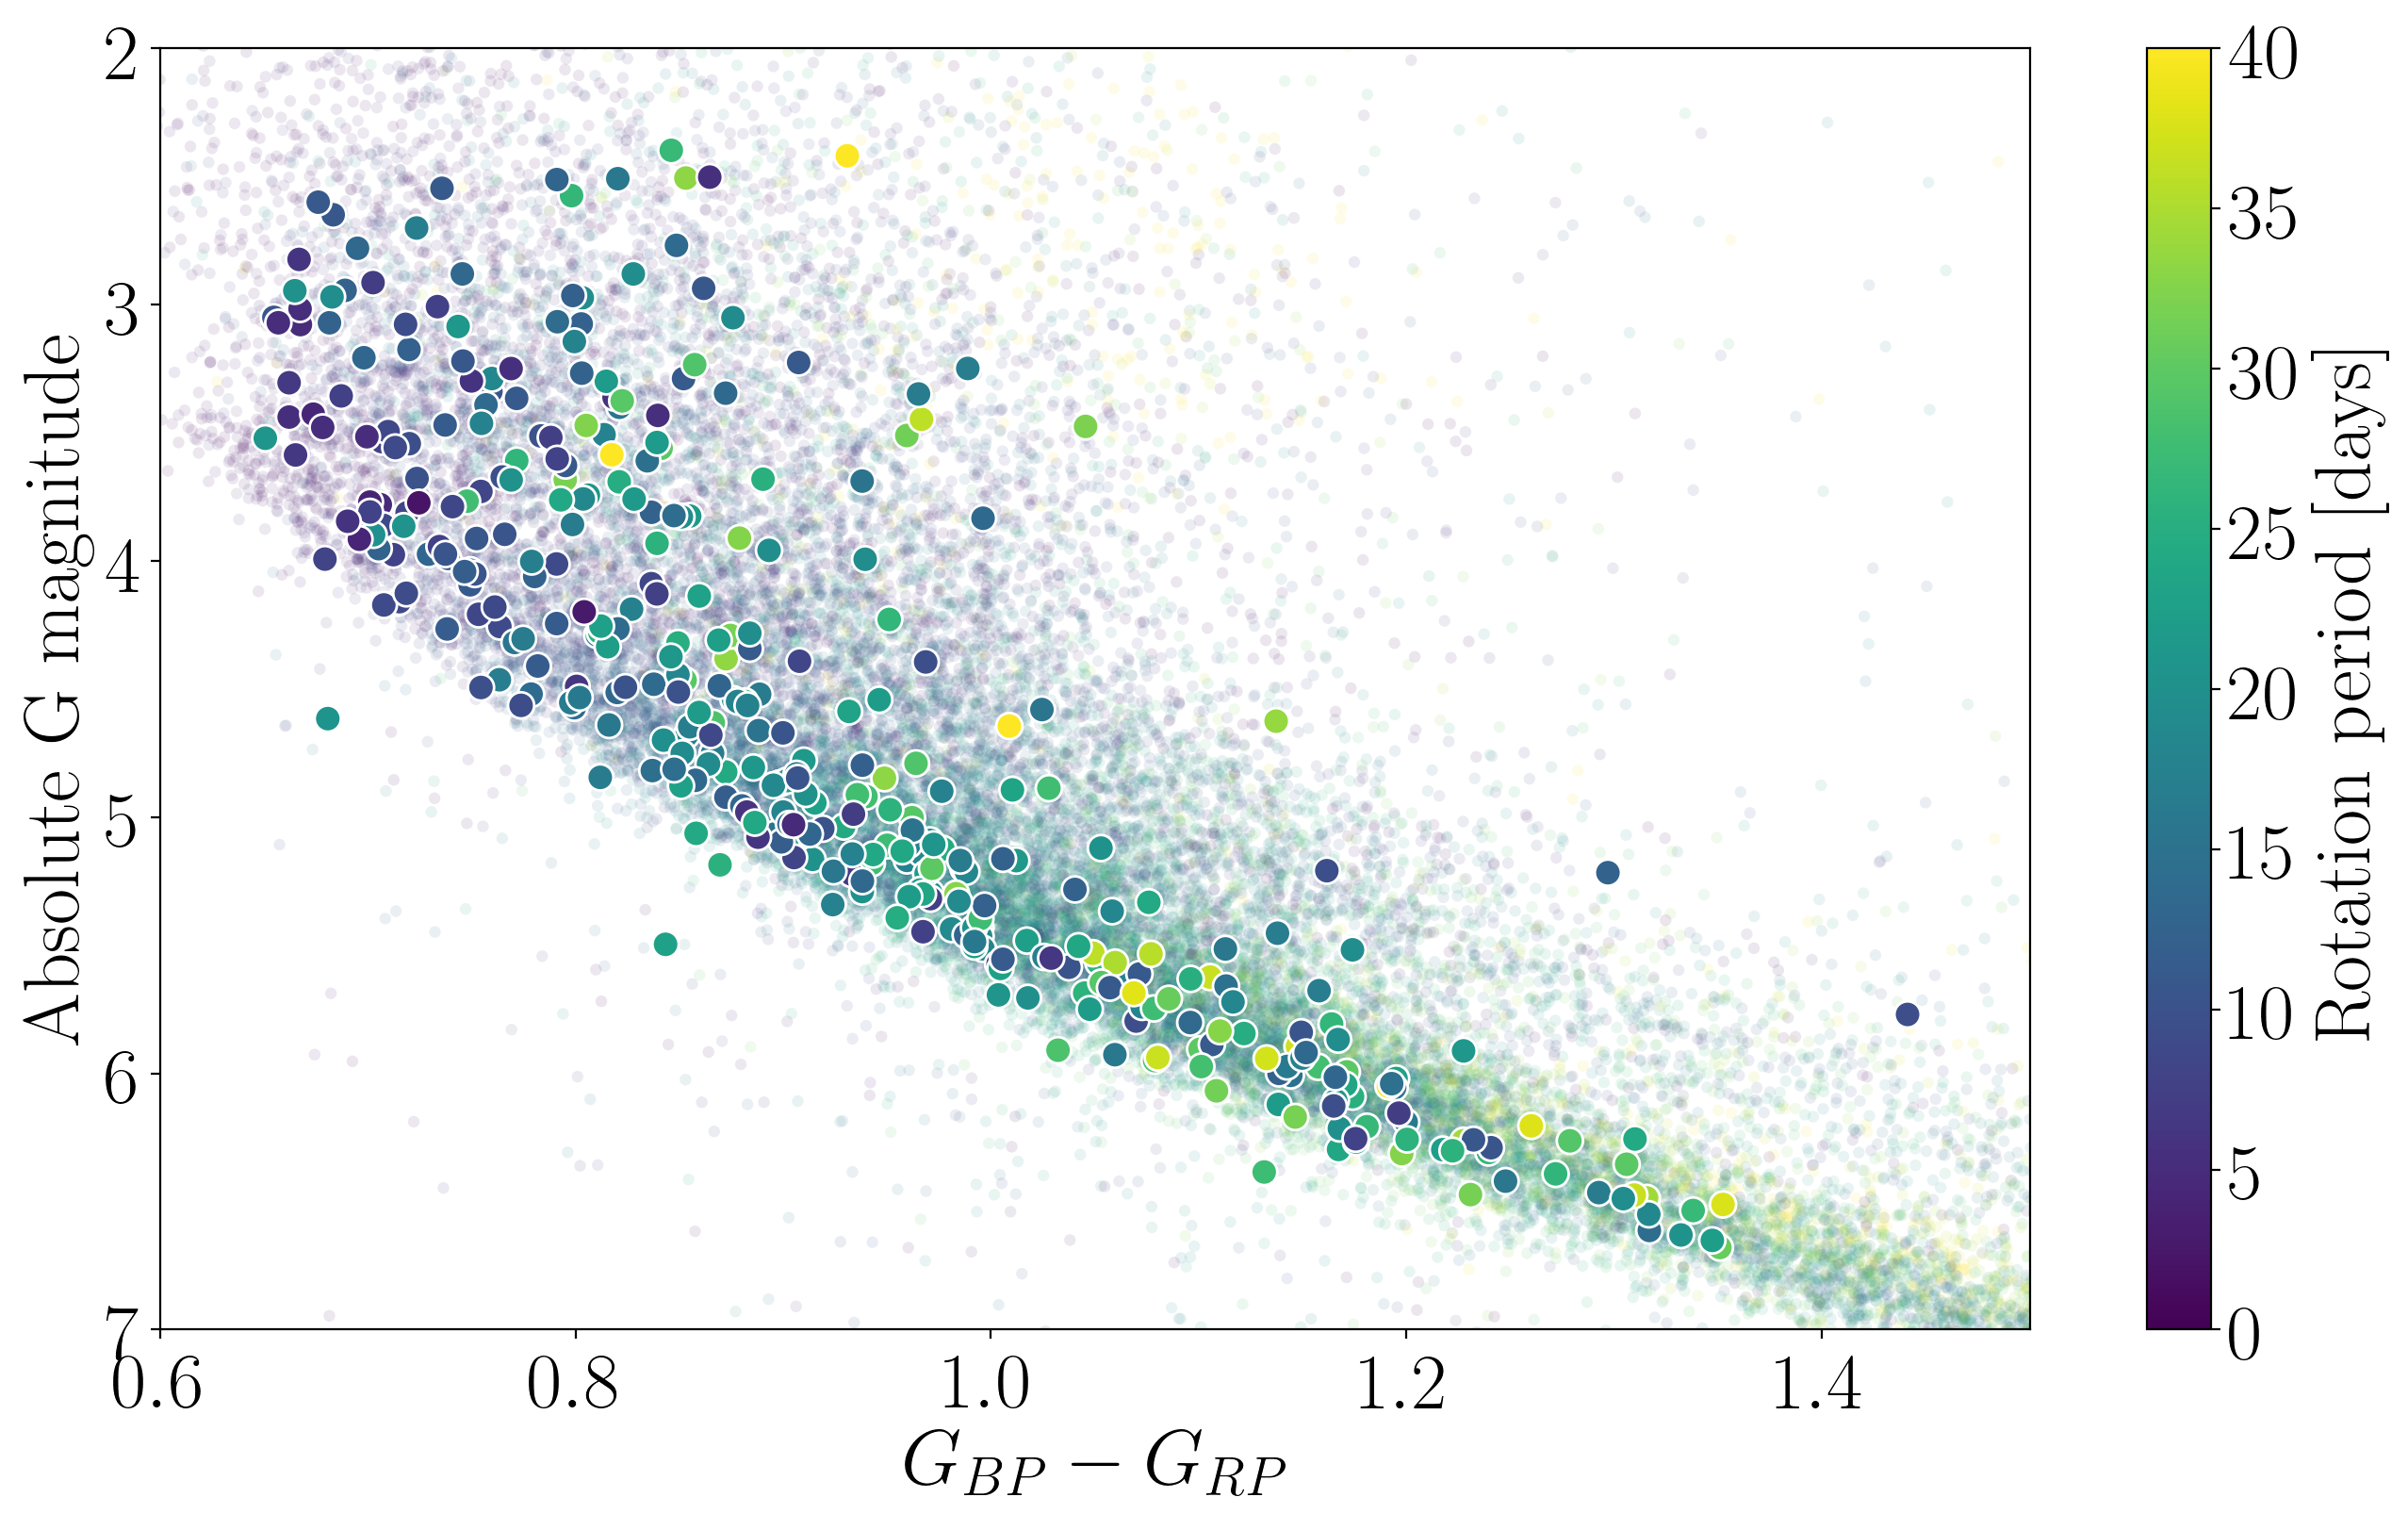

In [136]:
def m_to_M(m, D):
    """
    Convert apparent magnitude to absolute magnitude.
    """
    return m - 5*np.log10(abs(D)) + 5

mc["abs_G"] = m_to_M(mc.phot_g_mean_mag, (1./mc.parallax)*1e3)
ro1["abs_G"] = m_to_M(ro1.phot_g_mean_mag, (1./ro1.parallax)*1e3)

plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(mc.phot_bp_mean_mag - mc.phot_rp_mean_mag, mc.abs_G,
            c=mc.Prot, s=20, alpha=.1, vmin=0, vmax=40, edgecolor="none");
plt.gca().invert_yaxis()
# plt.ylim(12, -1)
plt.ylim(7, 2)
plt.xlim(.6, 1.5)
color_bar = plt.colorbar(label="$\mathrm{Rotation~period~[days]}$")
color_bar.set_alpha(1)
color_bar.draw_all()
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$\mathrm{Absolute~G~magnitude}$");

plt.scatter(ro1.phot_bp_mean_mag.values[m] - ro1.phot_rp_mean_mag.values[m],
            ro1.abs_G.values[m], c=ro1.Prot.values[m],
            s=100, vmin=0, vmax=40, edgecolor="w");

In [137]:
ro = ro1.iloc[m]

Calc Gaia noise.

In [138]:
def color_err(c):
    c_err = np.zeros(len(c))
    bright = c < 13
    medium = (13 < c) * (c < 17)
    faint = 17 <= c
    c_err[bright] = np.ones(len(c_err[bright]))*.002
    c_err[medium] = np.ones(len(c_err[medium]))*.01
    c_err[faint] = np.ones(len(c_err[faint]))*.2
    return c_err


def photometric_noise(G, bp, rp):
    G_err = np.zeros(len(G))
    bright = G < 13
    medium = (13 < G) * (G < 17)
    faint = 17 <= G
    G_err[bright] = np.ones(len(G_err[bright]))*.0003
    G_err[medium] = np.ones(len(G_err[medium]))*.002
    G_err[faint] = np.ones(len(G_err[faint]))*.01

    bp_err = color_err(bp)
    rp_err = color_err(rp)
    
    parallax_err = np.zeros(len(G))
    bright = G < 15
    medium = (15 < G) * (G < 17)
    faint = (17 < G) * (G < 20)
    ultra_faint = 20 <= G
    parallax_err[bright] = .03  # milliarcseconds
    parallax_err[medium] = .1
    parallax_err[faint] = .7
    parallax_err[ultra_faint] = 2
    
    return G_err, bp_err, rp_err, parallax_err

In [139]:
G_err, bp_err, rp_err, parallax_err = photometric_noise(ro.phot_g_mean_mag,
                                                        ro.phot_bp_mean_mag, 
                                                        ro.phot_rp_mean_mag)

/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


In [140]:
ro["G_err"] = G_err
ro["bp_err"] = bp_err
ro["rp_err"] = rp_err
ro["parallax_err"] = parallax_err

Calculate reddening.

In [141]:
from astropy.coordinates import SkyCoord
from dustmaps.bayestar import BayestarQuery
import astropy.units as units

bayestar = BayestarQuery(max_samples=2, version='bayestar2019')

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 30.590 s
  pix_info:   0.723 s
   samples:  13.500 s
      best:   6.376 s
       nan:   0.382 s
      sort:   9.252 s
       idx:   0.356 s


In [142]:
from getdust import getDust

coords = SkyCoord(ro.ra.values*units.deg, ro.dec.values*units.deg,
                  distance=ro.r_est.values*units.pc)

ebv, flags = bayestar(coords, mode='percentile', pct=[16., 50., 84.],
                      return_flags=True)

# Calculate Av
Av_bayestar = 2.742 * ebv
Av = Av_bayestar[:, 1]
Av_errm = Av - Av_bayestar[:, 0]
Av_errp = Av_bayestar[:, 2] - Av
Av_std = .5*(Av_errm + Av_errp)

# Catch places where the extinction uncertainty is zero and default to an
# uncertainty of .05
m = Av_std == 0
Av_std[m] = .05

ro["ebv"] = ebv[:, 1]  # The median ebv value.
ro["Av"] = Av
ro["Av_errp"] = Av_errp
ro["Av_errm"] = Av_errm
ro["Av_std"] = Av_std

# Calculate dereddened photometry
AG, Abp, Arp = getDust(ro.phot_g_mean_mag.values,
                       ro.phot_bp_mean_mag.values,
                       ro.phot_rp_mean_mag.values,
                       ro.ebv.values)

ro["bp_dered"] = ro.phot_bp_mean_mag.values - Abp
ro["rp_dered"] = ro.phot_rp_mean_mag.values - Arp
ro["bprp_dered"] = ro["bp_dered"] - ro["rp_dered"]
ro["G_dered"] = ro.phot_g_mean_mag.values - AG

/anaconda3/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/anaconda3/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/anaconda3/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/anaconda3/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/anaconda3/lib/python3.7/site-packages/astropy/coordinates/distances.py:183: RuntimeWarning: invalid value encountered in less
  if not allow_negative and np.any(distance.value < 0):
/anaconda3/lib/

In [143]:
ro.to_csv("cks_gaia_mazeh.csv")

In [187]:
i = 1
iso_params = {"G": (ro.phot_g_mean_mag.values[i], ro.G_err.values[i]),
              "BP": (ro.phot_bp_mean_mag.values[i], ro.bp_err.values[i]),
              "RP": (ro.phot_rp_mean_mag.values[i], ro.rp_err.values[i]),
              "teff": (ro.cks_steff.values[i], ro.cks_steff_err1.values[i]),
              "feh": (ro.cks_smet.values[i], ro.cks_smet_err1.values[i]),
              "logg": (ro.cks_slogg.values[i], ro.cks_slogg_err1.values[i]),
              "parallax": (ro.parallax.values[i], ro.parallax_error.values[i])}

Make CMD and gyro plots.

In [283]:
def make_cmd_gyro_plot(mc, ro, i):
    fig = plt.figure(figsize=(16, 6))
    ax1 = fig.add_subplot(121)
    ax1.plot(mc.Teff, mc.Prot, "k.", alpha=.1)
    ax1.plot(ro.cks_steff.values[i], ro.period.values[i], "C1o")
    ax1.set_xlim(6800, 3000)
    ax1.set_yscale("log")
    ax1.set_ylabel("$\mathrm{Rotation~period~[days]}$")
    ax1.set_xlabel("$\mathrm{T_{eff}}$")

    ax2 = fig.add_subplot(122)
    cb = ax2.scatter(mc.phot_bp_mean_mag - mc.phot_rp_mean_mag, mc.abs_G,
                c=mc.Prot, s=20, alpha=.1, vmin=0, vmax=40, edgecolor="none");
    ax2.set_ylim(7, 2)
    ax2.set_xlim(.6, 1.5)
    color_bar = plt.colorbar(cb, ax=ax2, label="$\mathrm{Rotation~period~[days]}$")
    color_bar.set_alpha(1)
    color_bar.draw_all()

    ax2.set_xlabel("$G_{BP} - G_{RP}$")
    ax2.set_ylabel("$\mathrm{Absolute~G~magnitude}$");

    ax2.scatter([ro.phot_bp_mean_mag.values[i] - ro.phot_rp_mean_mag.values[i]],
                [ro.abs_G.values[i]], c=[ro.Prot.values[i]],
                s=100, vmin=0, vmax=40, edgecolor="w");
    return fig

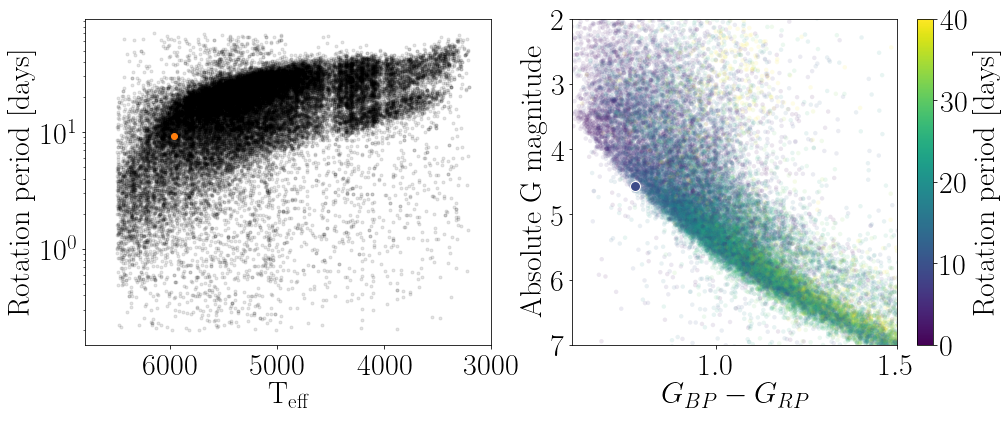

In [282]:
make_cmd_gyro_plot(mc, ro, i)

Calculate the Gyro age.

In [190]:
from stardate.lhf import age_model

bprp = ro.phot_bp_mean_mag.values[i] - ro.phot_rp_mean_mag.values[i]
log10_period = np.log10(ro.Prot.values[i])
log10_age_yrs = age_model(log10_period, bprp)
gyro_age = (10**log10_age_yrs)*1e-9
print("Gyro age = ", gyro_age, "Gyr")
print("Rotation period = ", ro.Prot.values[i], "BP-RP = ", bprp)

Gyro age =  4.273729079841484 Gyr
Rotation period =  24.99 BP-RP =  0.8210907


Isochrone age:

In [191]:
# Get initial EEP:
from isochrones import get_ichrone
mist = get_ichrone('mist')
eep = mist.get_eep(ro.koi_smass.values[i], np.log10(gyro_age*1e9), ro.cks_smet.values[i], accurate=True)
print("mass = ", ro.koi_smass.values[i])

inits = [eep, np.log10(gyro_age*1e9), ro.cks_smet.values[i], (1./ro.parallax.values[i])*1e3, ro.Av.values[i]]
print(inits)

mass =  1.08
[372.9107093811035, 9.630806987912486, 0.102, 307.34263858605635, 0.02741999938711524]


In [180]:
import stardate as sd

iso_star = sd.Star(iso_params, Av=ro.Av.values[i], Av_err=ro.Av_std.values[i])
iso_star.fit(inits=inits, max_n=10000)

100%|██████████| 10000/10000 [01:08<00:00, 145.27it/s]

nsteps 10000 burnin 0


Combined age:

In [181]:
gyro_star = sd.Star(iso_params, prot=ro.Prot.values[i], prot_err=ro.e_Prot.values[i],
               Av=ro.Av.values[i], Av_err=ro.Av_std.values[i])
gyro_star.fit(max_n=10000)

100%|██████████| 10000/10000 [02:16<00:00, 73.11it/s]

nsteps 10000 burnin 0


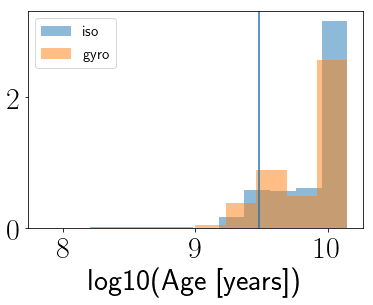

In [182]:
plt.hist(iso_star.samples[:, 1], density=True, alpha=.5, label="iso");
plt.hist(gyro_star.samples[:, 1], density=True, alpha=.5, label="gyro");
plt.axvline(np.log10(gyro_age*1e9))
plt.legend()
plt.xlabel("log10(Age [years])");

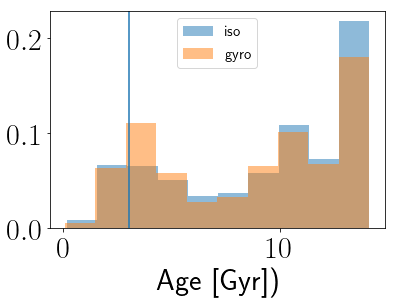

In [186]:
plt.hist((10**iso_star.samples[:, 1]*1e-9), density=True, alpha=.5, label="iso");
plt.hist((10**gyro_star.samples[:, 1]*1e-9), density=True, alpha=.5, label="gyro");
plt.axvline(gyro_age)
plt.legend()
plt.xlabel("Age [Gyr])");

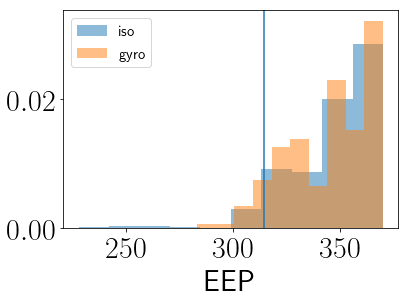

In [183]:
plt.hist(iso_star.samples[:, 0], density=True, alpha=.5, label="iso");
plt.hist(gyro_star.samples[:, 0], density=True, alpha=.5, label="gyro");
plt.axvline(eep)
plt.legend()
plt.xlabel("EEP");

In [184]:
plt.hist(iso_star.samples[:, 2], density=True, alpha=.5, label="iso");
plt.hist(gyro_star.samples[:, 2], density=True, alpha=.5, label="gyro");
plt.axvline(inits[2])
plt.legend()
plt.xlabel("[Fe/H]");

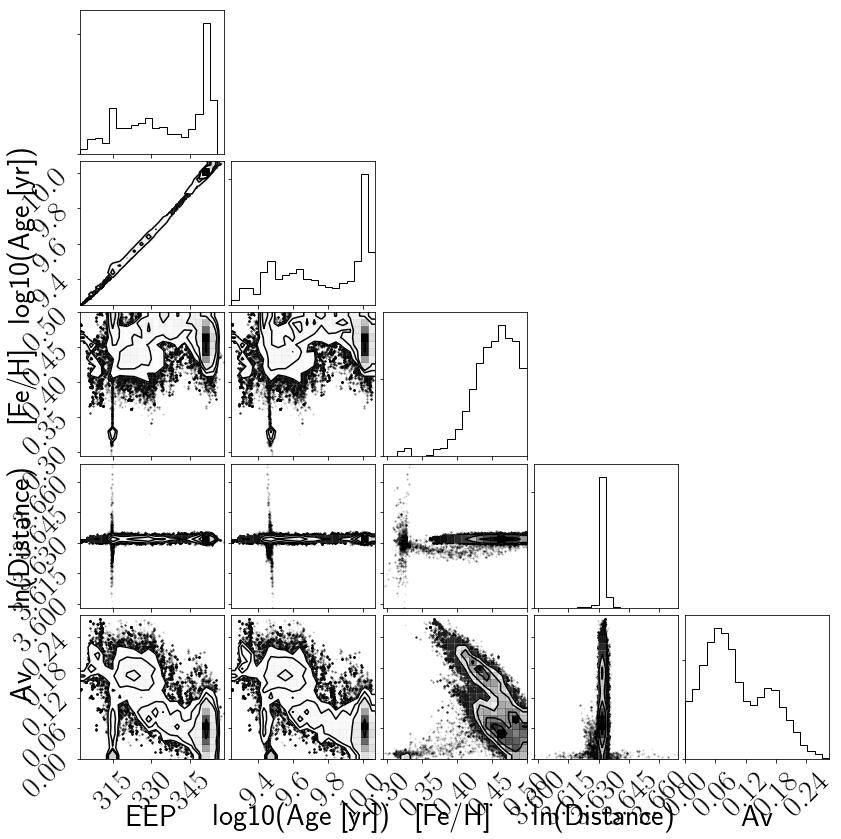

In [171]:
import corner

labels = ["EEP", "log10(Age [yr])", "[Fe/H]", "ln(Distance)", "Av", "ln(probability)"]

corner.corner(iso_star.samples, labels=labels);

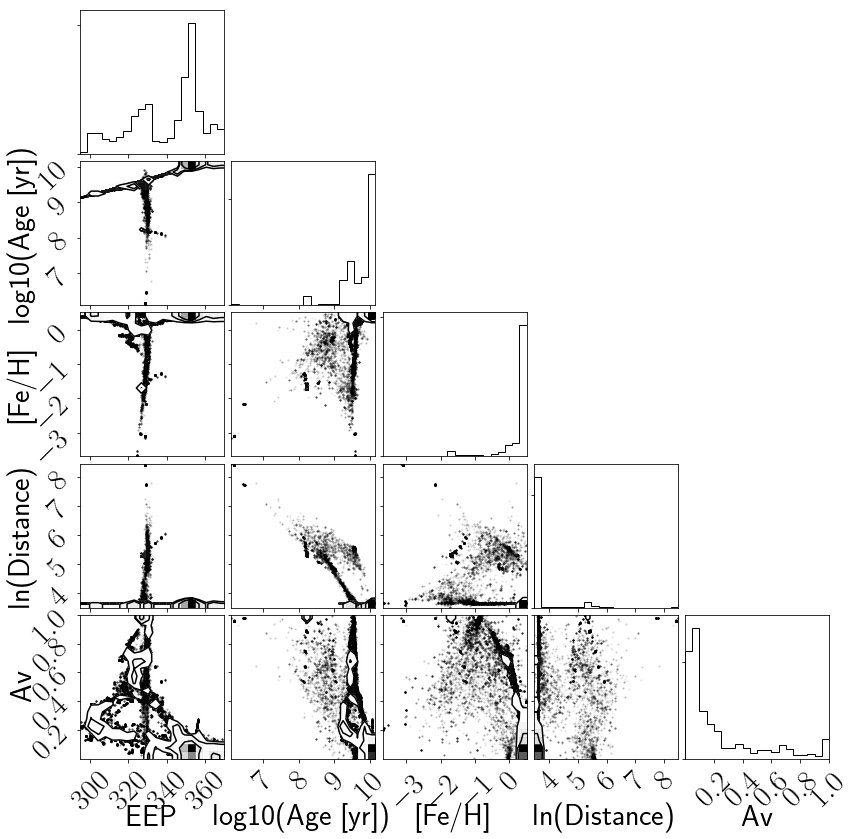

In [173]:
import corner

labels = ["EEP", "log10(Age [yr])", "[Fe/H]", "ln(Distance)", "Av", "ln(probability)"]

corner.corner(gyro_star.samples, labels=labels);

In [238]:
from stardate import load_samples, read_samples

# Load the samples.
flatsamples, _3Dsamples, posterior_samples, prior_samples = load_samples(
    "samples/001718958_gyro.h5", burnin=0)

# Extract the median and maximum likelihood parameter estimates from the samples.
results = read_samples(flatsamples)

# Print the results as a pandas dataframe.
results

EEP_med  EEP_errm  EEP_errp   EEP_std     EEP_ml  age_med_gyr  age_errm  \
0  320.743806   3.01025  4.107796  6.239064  320.52975     1.263859  0.118364   

   age_errp   age_std  age_ml_gyr  ...  distance_errm  distance_errp  \
0  0.186097  0.279042     1.25342  ...         4.1403       4.203174   

   distance_std_pc  distance_ml    Av_med   Av_errm   Av_errp    Av_std  \
0         4.193746   436.117057  0.165133  0.020175  0.020784  0.020908   

      Av_ml  index  
0  0.155451      0  

[1 rows x 26 columns]

In [235]:
m = ro.kepid == 1718958
i = int(np.arange(len(ro))[m])
i

362

In [236]:
# Calculate inits
from stardate.lhf import age_model
from isochrones import get_ichrone

def get_inits(ro, i):

    # Get gyro age
    bprp = ro.phot_bp_mean_mag.values[i] - ro.phot_rp_mean_mag.values[i]
    log10_period = np.log10(ro.Prot.values[i])
    log10_age_yrs = age_model(log10_period, bprp)
    gyro_age = (10**log10_age_yrs)*1e-9

    # Get initial EEP:
    mist = get_ichrone('mist')
    eep = mist.get_eep(ro.koi_smass.values[i], np.log10(gyro_age*1e9), ro.cks_smet.values[i], accurate=True)

    distance_pc = 1./(ro.parallax.values[i]*1e-3)
    inits = [eep, np.log10(gyro_age*1e9), ro.cks_smet.values[i], 
             np.log(distance_pc), ro.Av.values[i]]
    return inits

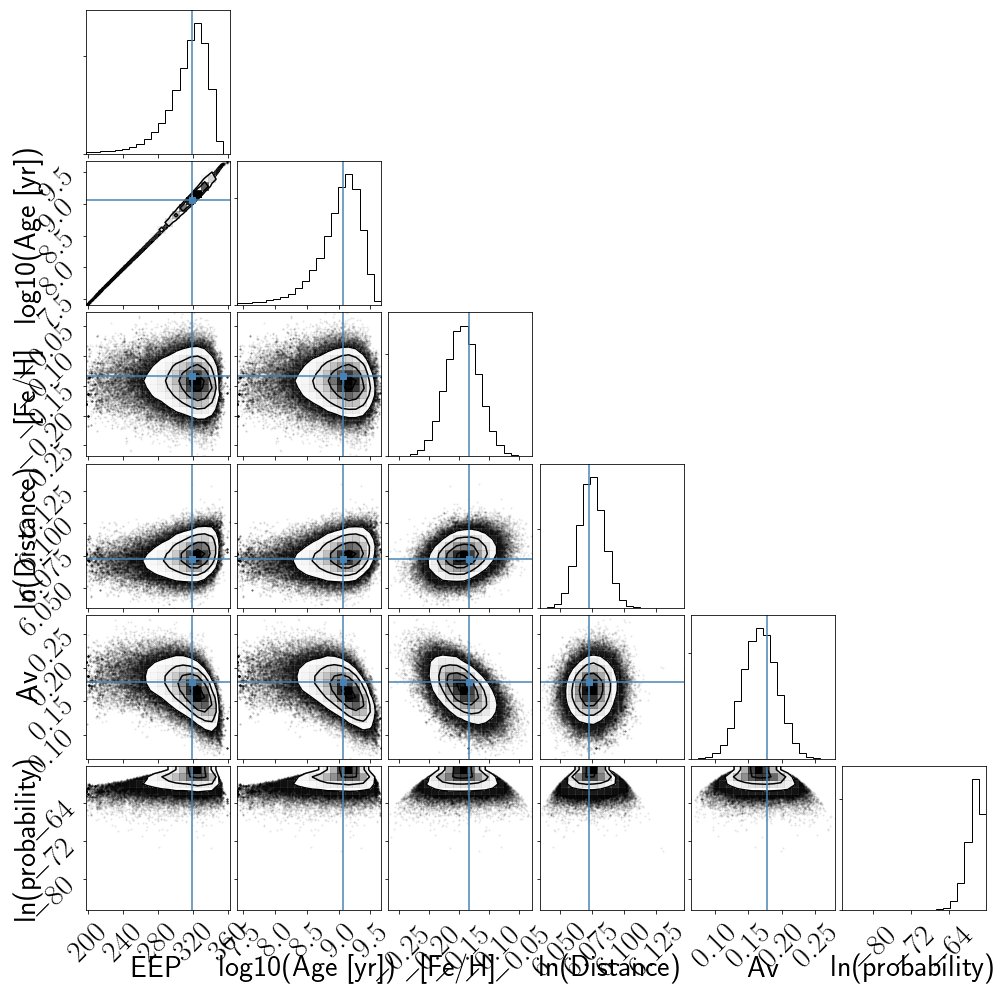

In [237]:
labels = ["EEP", "log10(Age [yr])", "[Fe/H]", "ln(Distance)", "Av", "ln(probability)"]

truths = get_inits(ro, i)
truths.append("None")
corner.corner(flatsamples, labels=labels, truths=truths);

Load all results.

In [279]:
import re

def get_index_from_filename(ro, filename):
    kepid = re.findall(r'\d+', filename)[0]
    m = ro.kepid.values == int(kepid)
    return int(np.arange(len(ro))[m]), kepid

In [ ]:
from stardate import load_samples, read_samples
import glob
filenames = glob.glob("samples/*gyro.h5")
print(len(filenames))

labels = ["EEP", "log10(Age [yr])", "[Fe/H]", "ln(Distance)", "Av", "ln(probability)"]
for fn in filenames:
    i, kepid = get_index_from_filename(ro, filenames[0])
    print(kepid)
    
    # Load the samples.
    flatsamples, _3Dsamples, posterior_samples, prior_samples = load_samples(fn, burnin=0)
    
    truths = get_inits(ro, i)
    truths.append("None")
    fig = corner.corner(flatsamples, labels=labels, truths=truths);
    fig.savefig("plots/{}_corner".format(kepid))
    
    fig2 = make_cmd_gyro_plot(mc, ro, i)
    fig2.savefig("plots/{}_cmd".format(kepid))

93
010647452
010647452
010647452
010647452


010647452
010647452
010647452
010647452


010647452
010647452


010647452
010647452


010647452
010647452
